# Run GODEC on fMRI data

Here, we adapt a nilearn example, "[Producing single subject maps of seed-to-voxel correlation](http://nilearn.github.io/auto_examples/03_connectivity/plot_seed_to_voxel_correlation.html#producing-single-subject-maps-of-seed-to-voxel-correlation)", to show how GODEC can be run on fMRI data, as well as the effect of GODEC denoising on seed-to-voxel functional connectivity.

In [1]:
%matplotlib inline
import os.path as op
import matplotlib.pyplot as plt

import numpy as np
from scipy import stats
from nilearn import datasets, image, input_data, plotting
import pandas as pd

import godec
from godec.tests.utils import get_test_data_path

/Users/taylor/Documents/tsalo/nilearn/nilearn/datasets/__init__.py:92: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
dataset = datasets.fetch_haxby()
func_filename = dataset.func[0]
anat_filename = dataset.anat[0]
brain_mask_filename = dataset.mask
face_mask_filename = dataset.mask_face[0]

In [3]:
initial_brain_masker = input_data.NiftiMasker(
    mask_img=brain_mask_filename,
    smoothing_fwhm=None,
    detrend=False, 
    standardize=False,
    low_pass=None, 
    high_pass=None, 
    t_r=2.5,
)

In [4]:
face_masker = input_data.NiftiLabelsMasker(
    face_mask_filename,
    labels={1: "face"},
    smoothing_fwhm=None,
    detrend=True, 
    standardize=True,
    low_pass=0.1, 
    high_pass=0.01, 
    t_r=2.5,
    strategy="mean",
)

final_brain_masker = input_data.NiftiMasker(
    mask_img=brain_mask_filename,
    smoothing_fwhm=6,
    detrend=True,
    standardize=True,
    low_pass=0.1,
    high_pass=0.01, 
    t_r=2.5,
)

In [5]:
raw_data = initial_brain_masker.fit_transform(func_filename)

<ipython-input-18-cd149213bc59>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


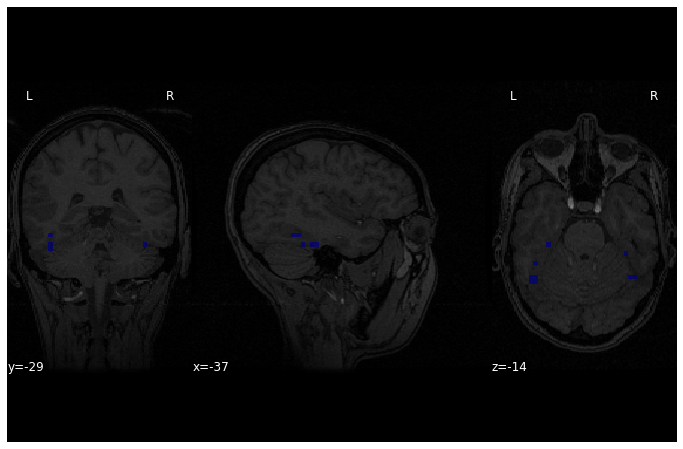

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
plotting.plot_roi(face_mask_filename, bg_img=anat_filename, axes=ax, figure=fig, draw_cross=False)
fig.show()

# Standard GoDec

In [6]:
lowrank, sparse, reconstruction, noise, rmse = godec.godec_standard(raw_data, rank=4, iterated_power=10)
lowrank = initial_brain_masker.inverse_transform(lowrank)
sparse = initial_brain_masker.inverse_transform(sparse)

imgs = {
    "Original Data": func_filename,
    "Low-Rank Components": lowrank,
    "Sparse Components": sparse,
}

Iteration: 0, RMSE: 0.0


<ipython-input-7-482e6fa80b00>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


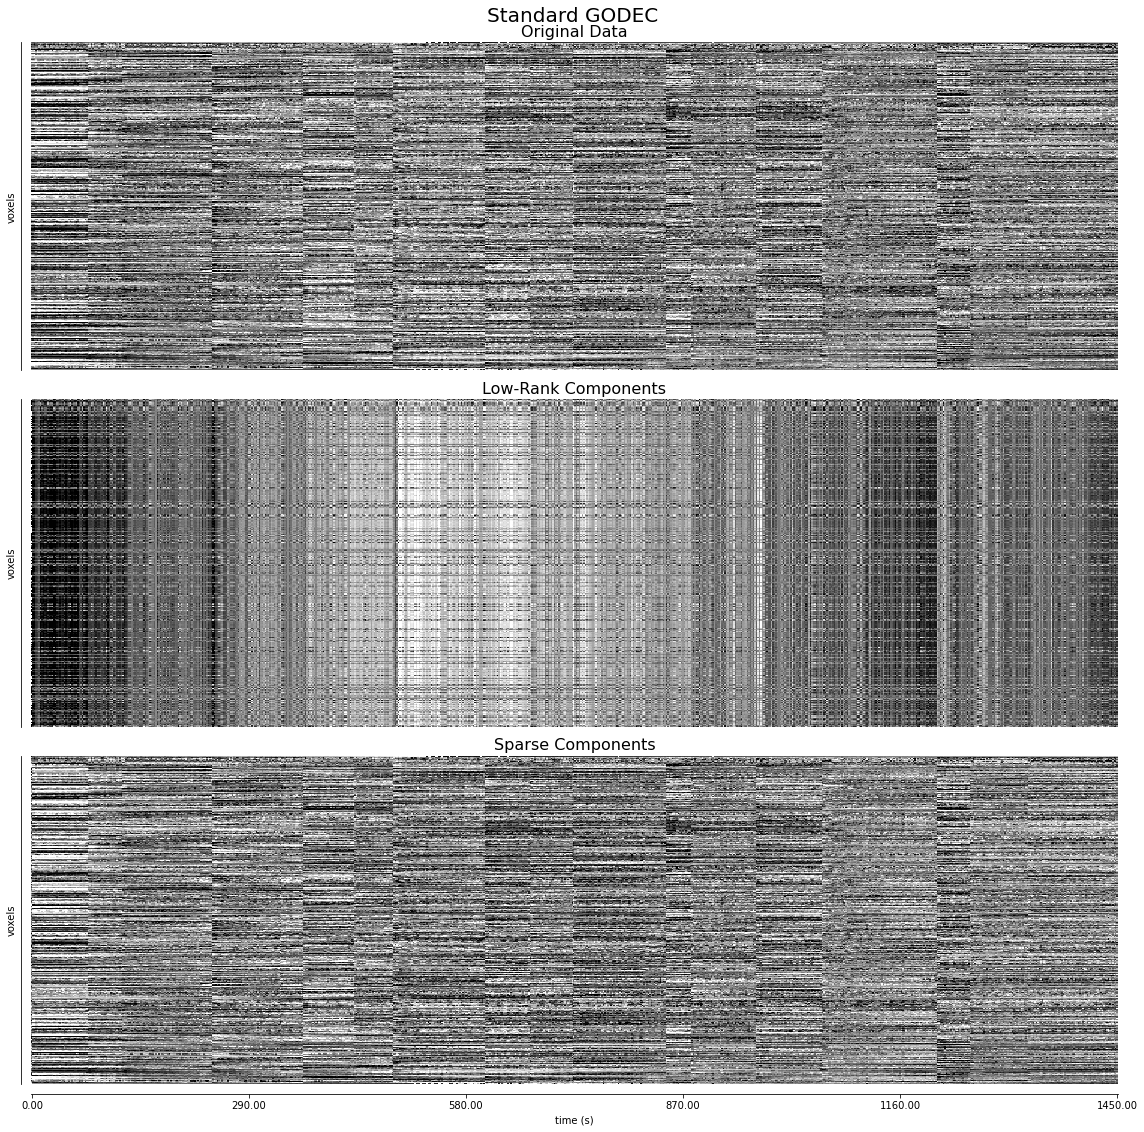

In [7]:
fig, axes = plt.subplots(figsize=(16, 16), nrows=3)

for i, (name, img) in enumerate(imgs.items()):
    plotting.plot_carpet(
        img, 
        mask_img=initial_brain_masker.mask_img, 
        axes=axes[i], 
        figure=fig,
    )
    axes[i].set_title(name, fontsize=16)

axes[0].set_xticklabels([])
axes[1].set_xticklabels([])
axes[0].set_xticks([])
axes[1].set_xticks([])
axes[0].set_xlabel(None)
axes[1].set_xlabel(None)
axes[0].spines["bottom"].set_visible(False)
axes[1].spines["bottom"].set_visible(False)

fig.suptitle("Standard GODEC", fontsize=20)
fig.tight_layout()
fig.show()

In [8]:
# Run seed-to-voxel correlations
correlation_imgs = {}
for img_name, img in imgs.items():
    seed_ts = face_masker.fit_transform(img)
    brain_ts = final_brain_masker.fit_transform(img)

    seed_to_voxel_corrs = (np.dot(brain_ts.T, seed_ts) / seed_ts.shape[0]).T
    seed_to_voxel_img = final_brain_masker.inverse_transform(seed_to_voxel_corrs)
    correlation_imgs[img_name] = seed_to_voxel_img

<ipython-input-9-7b0ff0d912fa>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


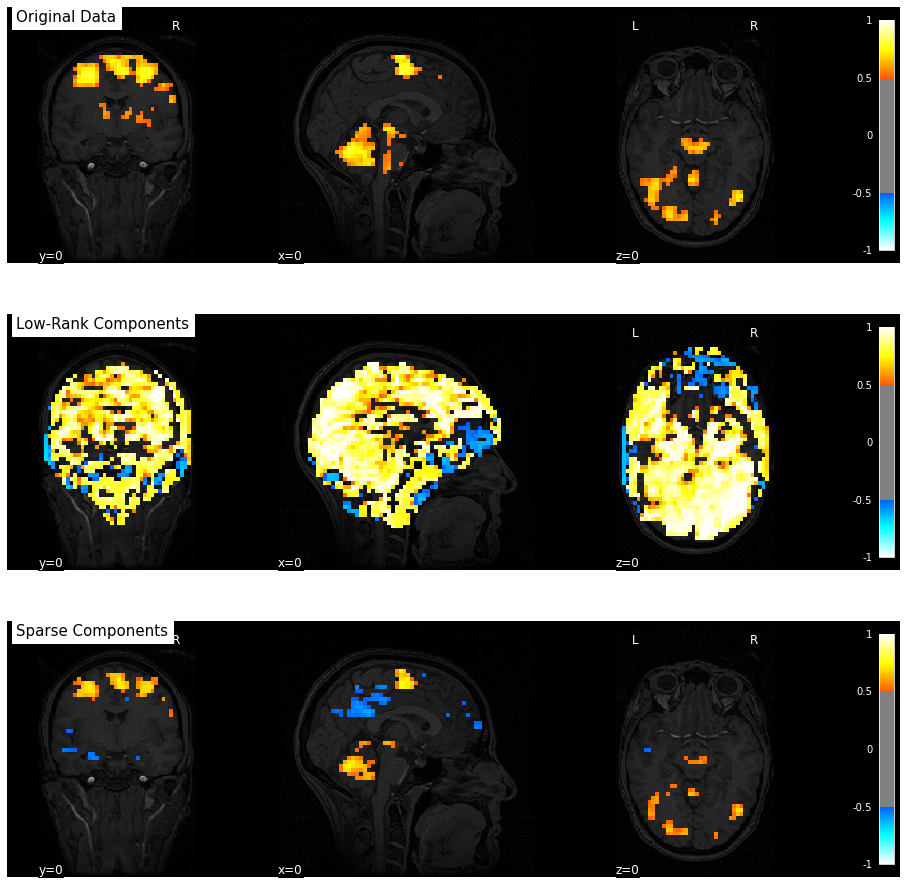

In [9]:
fig, axes = plt.subplots(figsize=(16, 16), nrows=len(correlation_imgs))

for i_img, (img_name, img) in enumerate(correlation_imgs.items()):
    display = plotting.plot_stat_map(
        img,
        bg_img=anat_filename,
        threshold=0.5, 
        vmax=1,
        cut_coords=[0, 0, 0],
        title=img_name,
        axes=axes[i_img],
        figure=fig,
        draw_cross=False,
    )

fig.show()

# Greedy Semi-Soft GoDec

In [10]:
lowrank, sparse, reconstruction, noise, error = godec.godec_greedy_semisoft(raw_data, rank=4, iterated_power=25)
lowrank = initial_brain_masker.inverse_transform(lowrank)
sparse = initial_brain_masker.inverse_transform(sparse)

imgs = {
    "Original Data": func_filename,
    "Low-Rank Components": lowrank,
    "Sparse Components": sparse,
}

rank_step: 2, iteration: 0, rrank: 4, alf: 0


/Users/taylor/Documents/tsalo/godec/godec/decomposition.py:317: RuntimeWarning: divide by zero encountered in double_scalars
  rel_drp = (rank - 1) * dmx / (sum(drops) - dmx)


rank_step: 2, iteration: 1, rrank: 4, alf: 1.0
rank_step: 2, iteration: 2, rrank: 4, alf: 2.0
rank_step: 2, iteration: 3, rrank: 4, alf: 3.0
rank_step: 2, iteration: 4, rrank: 4, alf: 4.0
rank_step: 2, iteration: 5, rrank: 4, alf: 5.0
rank_step: 2, iteration: 6, rrank: 4, alf: 6.25
rank_step: 2, iteration: 7, rrank: 4, alf: 7.8125
rank_step: 2, iteration: 8, rrank: 4, alf: 9.765625
Detecting average decrease in error of <= 8% over past 7 iterations, indicating stabilization (I guess). Stopping early.
rank_step: 4, iteration: 0, rrank: 4, alf: 0
rank_step: 4, iteration: 1, rrank: 4, alf: 1.0
rank_step: 4, iteration: 2, rrank: 4, alf: 2.0
rank_step: 4, iteration: 3, rrank: 4, alf: 3.0
rank_step: 4, iteration: 4, rrank: 4, alf: 4.0
rank_step: 4, iteration: 5, rrank: 4, alf: 5.0
rank_step: 4, iteration: 6, rrank: 4, alf: 6.25
rank_step: 4, iteration: 7, rrank: 4, alf: 7.8125
rank_step: 4, iteration: 8, rrank: 4, alf: 9.765625
Detecting average decrease in error of <= 8% over past 7 iterati

<ipython-input-11-ebc801fceb4b>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


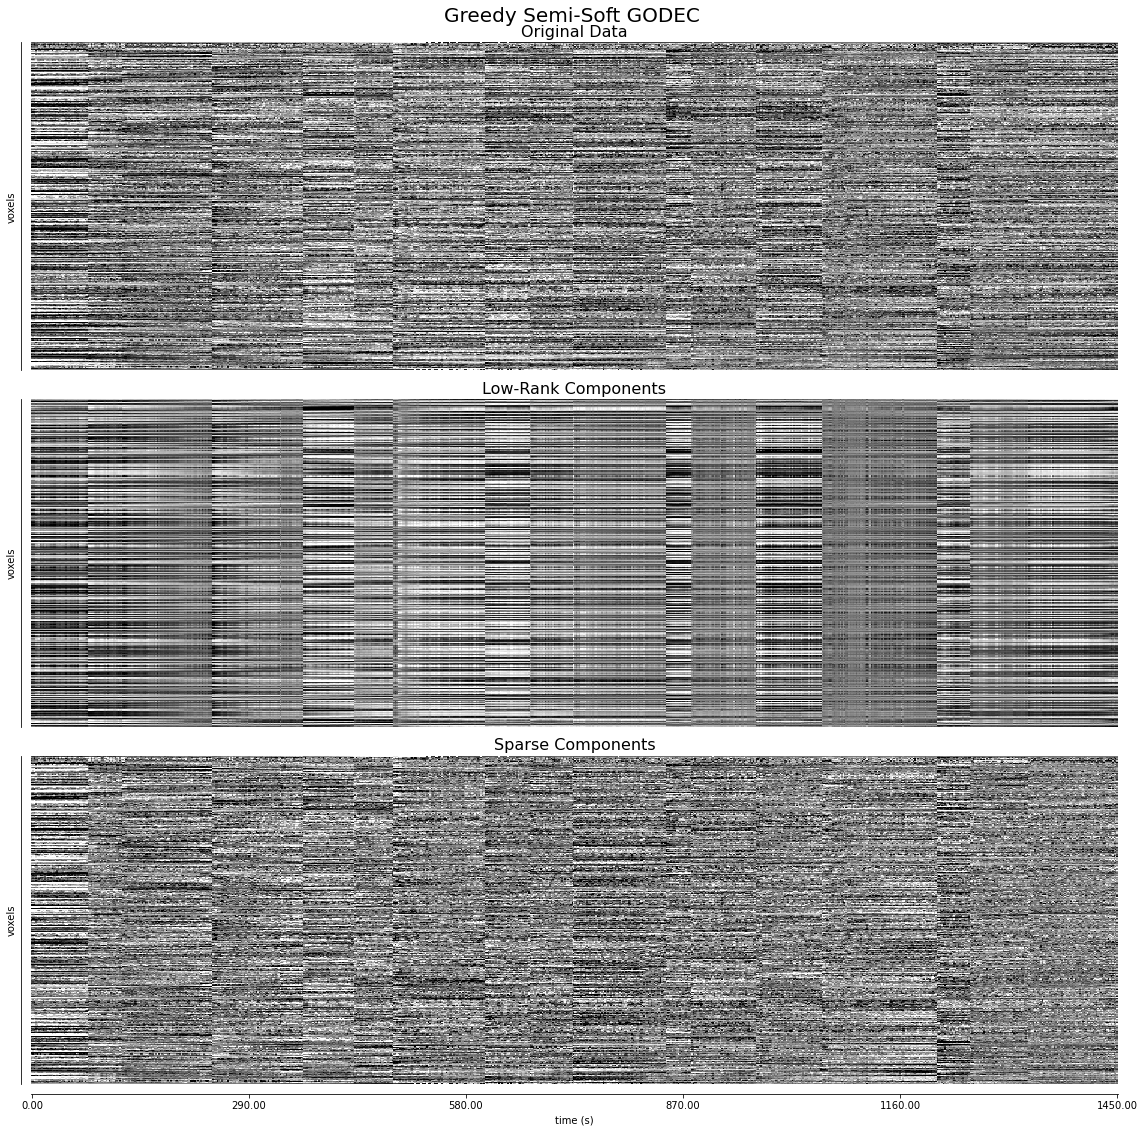

In [11]:
fig, axes = plt.subplots(figsize=(16, 16), nrows=3)

for i, (name, img) in enumerate(imgs.items()):
    plotting.plot_carpet(
        img, 
        mask_img=initial_brain_masker.mask_img, 
        axes=axes[i], 
        figure=fig,
    )
    axes[i].set_title(name, fontsize=16)

axes[0].set_xticklabels([])
axes[1].set_xticklabels([])
axes[0].set_xticks([])
axes[1].set_xticks([])
axes[0].set_xlabel(None)
axes[1].set_xlabel(None)
axes[0].spines["bottom"].set_visible(False)
axes[1].spines["bottom"].set_visible(False)

fig.suptitle("Greedy Semi-Soft GODEC", fontsize=20)
fig.tight_layout()
fig.show()

In [12]:
# Run seed-to-voxel correlations
correlation_imgs = {}
for img_name, img in imgs.items():
    seed_ts = face_masker.fit_transform(img)
    brain_ts = final_brain_masker.fit_transform(img)

    seed_to_voxel_corrs = (np.dot(brain_ts.T, seed_ts) / seed_ts.shape[0]).T
    seed_to_voxel_img = final_brain_masker.inverse_transform(seed_to_voxel_corrs)
    correlation_imgs[img_name] = seed_to_voxel_img

<ipython-input-13-7b0ff0d912fa>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


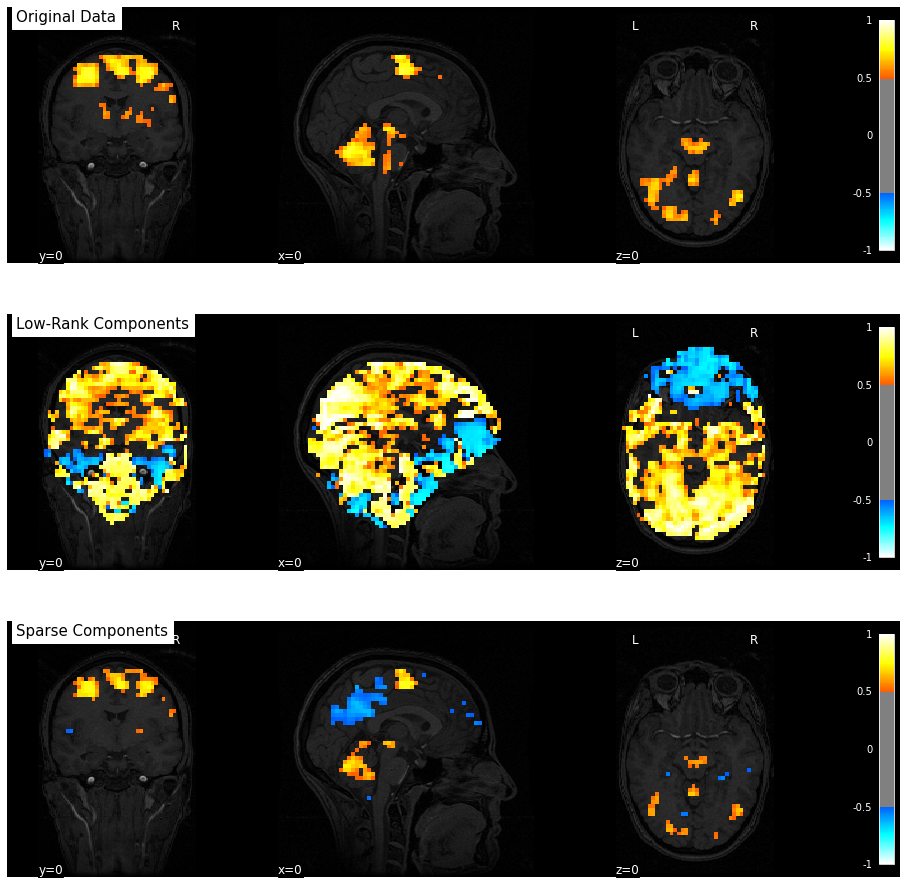

In [13]:
fig, axes = plt.subplots(figsize=(16, 16), nrows=len(correlation_imgs))

for i_img, (img_name, img) in enumerate(correlation_imgs.items()):
    display = plotting.plot_stat_map(
        img,
        bg_img=anat_filename,
        threshold=0.5, 
        vmax=1,
        cut_coords=[0, 0, 0],
        title=img_name,
        axes=axes[i_img],
        figure=fig,
        draw_cross=False,
    )

fig.show()